# Setup

In [47]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std

In [3]:
import statsmodels.formula.api as smf

In [4]:
plt.style.use('fivethirtyeight')

# Data visualization ― week 4

![](images/weightedreg1.png)

# Agenda

* Week 3 wrap-up
* Problem set discussion
* Visualizing statistical estimates and fits
    - uncertainty in estimates
    - plotting causal effects estimated via regression
    - comparing causal effects across groups

# Uncertainty in estimates

When it comes to visualize the output of statistical analyses, there are two forms of uncertainty the could be represented:

1. sometimes, we'd like to infer a quantity of interest in the population (e.g., average salary) - however, we have sample data only
2. sometimes, we'd like to infer the effect of an independent variable $X$ on a dependent variable $Y$ (e.g., the effect of schooling on salary) - however, the $X - Y$ effect is estimated via a regression model or machine learning. Irrespective of the method, we want to 'precision' of our estimate is properly reflected in the visualization we propose. 

# Case 1: Sample estimate Vs. population value

Let's use the killer app data to show the uncertainty in the 

In [5]:
# read data
df = pd.read_csv('data/killerAps/data.csv')

In [6]:
# get a random sample containing 1%
# of the apps in the population
smp = df.sample(frac=0.01)

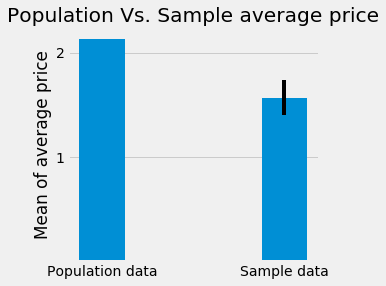

In [7]:
# create figure
fig = plt.figure(figsize=(4, 4))

# parms for the figure
width = 0.25

# add plot
ax = fig.add_subplot(1, 1, 1)

# get data series
pos = (0, 1)
labels = ('Population data', 'Sample data')
means = (np.mean(df['avprice']), np.mean(smp['avprice']))
err = (0, np.std(smp['avprice'])/np.sqrt(len(smp)))

# quick and dirty plot
ax.bar(pos, means, width, yerr=err)

# labels
ax.set_ylabel('Mean of average price')
ax.set_yticks((1, 2))
ax.set_title('Population Vs. Sample average price')
ax.set_xticks(pos)
ax.set_xticklabels(labels)

# remove grid
ax.grid(axis='x')

# show plot
plt.show()

# Case 2: Plotting estimates from statistical models 

## OLS regression model in a nutshell

Given the eqquation linking the endogenous (dependent) variable $y$ to the endogenous variables (predictors) $X$:

\begin{equation}
    y = \alpha + \beta_{1} * x_{1} + \beta_{2} * x_{2} + ... + \beta_{k} * x_{k} + \epsilon
\end{equation}

We want to find the best estimates for params $\hat{\beta_{i}}$. The OLS estimator 'solves'the problem by retaining the vector of parameters $\hat{\beta}$ that minimizes the following quantity:

\begin{equation}
        RSS = \sum_{i = 1}^{n} (y_i - \hat{y_i})^{2}
\end{equation}

that is, the sum of the squares of the differences between observed values ($y_{i}$) and model predictions ($y_{i}$)

## Estimation

In [8]:
"""
Let's regress the quality of an app (i.e., the average rating)
on as series of factors, such as:

1 - the attention received by the app in the platform ('lnnumcomapp'; log transformed)
2 - the complexity of the app ('avsize')
3 - the count of previous versions of the app ('numverapp')
4 - the experience of the entrepreneur ('countapp')
5 - the fact that app has been updated during the timespan of the study ('noupdates')
"""

# define the regression model
m_0 = sm.OLS(endog=df['scoreapp'],
             exog=df[['lnnumcomapp', 'avsize', 'numverapp', 'countapp', 'noupdates']],
             hasconst=None)

In [9]:
# fit the model
m_0_res = m_0.fit()

print(m_0_res.summary())

                                 OLS Regression Results                                
Dep. Variable:               scoreapp   R-squared (uncentered):                   0.611
Model:                            OLS   Adj. R-squared (uncentered):              0.611
Method:                 Least Squares   F-statistic:                          1.140e+04
Date:                Mon, 21 Oct 2019   Prob (F-statistic):                        0.00
Time:                        18:43:22   Log-Likelihood:                         -74245.
No. Observations:               36349   AIC:                                  1.485e+05
Df Residuals:                   36344   BIC:                                  1.485e+05
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
                  coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------

In [10]:
# we can also pass a formula in natural language
m_0 = smf.ols('scoreapp ~ lnnumcomapp + avsize + numverapp + countapp + noupdates',
              data = df)

In [11]:
# fit the model
m_0_res = m_0.fit()

# print the results of the model
print(m_0_res.summary())

'''
Warning: By default, using the 'formula' alternatives adds an intercept to the model
'''

                            OLS Regression Results                            
Dep. Variable:               scoreapp   R-squared:                       0.325
Model:                            OLS   Adj. R-squared:                  0.325
Method:                 Least Squares   F-statistic:                     3496.
Date:                Mon, 21 Oct 2019   Prob (F-statistic):               0.00
Time:                        18:43:22   Log-Likelihood:                -72380.
No. Observations:               36349   AIC:                         1.448e+05
Df Residuals:                   36343   BIC:                         1.448e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       1.8460      0.029     62.676      

"\nWarning: By default, using the 'formula' alternatives adds an intercept to the model\n"

## Plotting individual regression slopes

In [12]:
# get confidence intervals
estimates = m_0_res.conf_int(alpha = 0.05)

In [13]:
# reindex data
estimates.reset_index(inplace=True)

In [14]:
# rename columns
estimates.rename(columns={'index': 'variable',
                          0: 'lower_bound',
                          1: 'upper_bound'}, inplace=True)

In [15]:
# recall and attach betas
estimates.loc[:, 'beta'] = list(m_0_res.params)

In [16]:
# reindex data
estimates.set_index('variable', inplace=True)

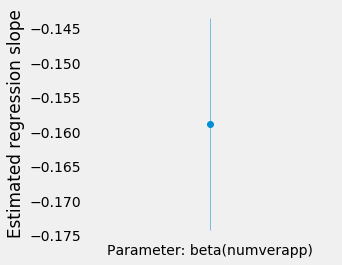

In [17]:
# create figure 
fig = plt.figure(figsize=(4, 4))

# add plot
ax = fig.add_subplot(1, 1, 1)

# focal variable
var = 'numverapp'

# data series
x = 0
y = estimates.loc[var, 'beta']
y_high = estimates.loc[var, 'upper_bound']
y_low = estimates.loc[var, 'lower_bound']

# plot data
ax.errorbar(x, y, fmt='o',
            yerr=np.absolute(y_low - y_high)/2,
            elinewidth=0.5)

# axes
ax.set_xticks((-0.1, 0, .1))
ax.set_xticklabels(('', 'Parameter: beta(numverapp)', ''))
ax.set_ylabel('Estimated regression slope')

# remove grid
ax.grid()

# show plot
plt.show()

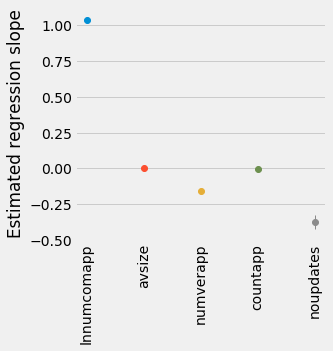

In [18]:
'''
Let's consider multiple parameters in a row
'''

# create figure 
fig = plt.figure(figsize=(4, 4))

# add plot
ax = fig.add_subplot(1, 1, 1)

# focal variable
preds = estimates.index[1:]

# let's iterate over the variables included in the model
for i, pred in enumerate(preds):

    # data series
    x = i
    y = estimates.loc[pred, 'beta']
    y_high = estimates.loc[pred, 'upper_bound']
    y_low = estimates.loc[pred, 'lower_bound']

    # plot data
    ax.errorbar(x, y, fmt='o',
                yerr=np.absolute(y_low - y_high)/2,
                elinewidth=1)


# axes
ax.set_xticks(np.arange(len(preds)))
ax.set_xticklabels(preds, rotation=90)
ax.set_ylabel('Estimated regression slope')

# remove grid
ax.grid(axis='x')

# show plot
plt.show()

In [19]:
'''
The above displayed chart has a fundamental problem: Predictors have different
scales - so, comparing and contrastring the various slopes is difficult

A way to circumnvent the problem is standardizing predictors: 

z_score = (x - mean(x)) / std(x)

'''

preds = ['lnnumcomapp', 'avsize', 'numverapp', 'countapp', 'noupdates']

for pred in preds:
    df.loc[:, pred] = (df[pred] - np.mean(df[pred])) / np.std(df[pred]) 
    

# OR, using a lambda function:
# df[preds] = df.loc[:, preds].apply(lambda x: (x - np.mean(x)) / np.std(x))

In [20]:
# formula
m_0 = smf.ols('scoreapp ~ lnnumcomapp + avsize + numverapp + countapp + noupdates',
              data = df)

m_0_res = m_0.fit()

print(m_0_res.summary())

                            OLS Regression Results                            
Dep. Variable:               scoreapp   R-squared:                       0.325
Model:                            OLS   Adj. R-squared:                  0.325
Method:                 Least Squares   F-statistic:                     3496.
Date:                Mon, 21 Oct 2019   Prob (F-statistic):               0.00
Time:                        18:43:23   Log-Likelihood:                -72380.
No. Observations:               36349   AIC:                         1.448e+05
Df Residuals:                   36343   BIC:                         1.448e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       2.0702      0.009    222.675      

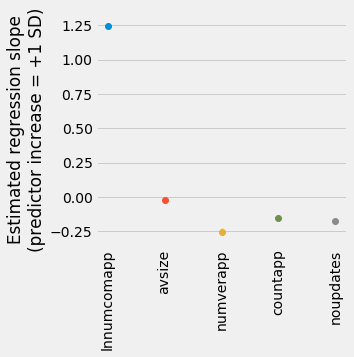

In [21]:
# formula
m_0 = smf.ols('scoreapp ~ lnnumcomapp + avsize + numverapp + countapp + noupdates',
              data = df)

# fit
m_0_res = m_0.fit()

# get confidence intervals
estimates = m_0_res.conf_int(alpha = 0.05)

# reindex data
estimates.reset_index(inplace=True)

# rename columns
estimates.rename(columns={'index': 'variable',
                          0: 'lower_bound',
                          1: 'upper_bound'}, inplace=True)

# recall and attach betas
estimates.loc[:, 'beta'] = list(m_0_res.params)

# reindex data
estimates.set_index('variable', inplace=True)

'''
Let's consider multiple parameters in a row
'''

# create figure 
fig = plt.figure(figsize=(4, 4))

# add plot
ax = fig.add_subplot(1, 1, 1)

# focal variable
preds = estimates.index[1:]

# let's iterate over the variables included in the model
for i, pred in enumerate(preds):

    # data series
    x = i
    y = estimates.loc[pred, 'beta']
    y_high = estimates.loc[pred, 'upper_bound']
    y_low = estimates.loc[pred, 'lower_bound']

    # plot data
    ax.errorbar(x, y, fmt='o',
                yerr=np.absolute(y_low - y_high)/2,
                elinewidth=1)


# axes
ax.set_xticks(np.arange(len(preds)))
ax.set_xticklabels(preds, rotation=90)
ax.set_ylabel('Estimated regression slope\n(predictor increase = +1 SD)')

# remove grid
ax.grid(axis='x')

# show plot
plt.show()

## Diagnostic plots

Statsmodels has a rich set of functions covering diagnostic plots

In [44]:
# sample 1% of the observations to improve
# the readability of the below-displayed chart
df = df.sample(frac=0.01)

# formula
m_0 = smf.ols('scoreapp ~ lnnumcomapp + avsize + numverapp + countapp + noupdates',
              data = df)

# fit
m_0_res = m_0.fit()

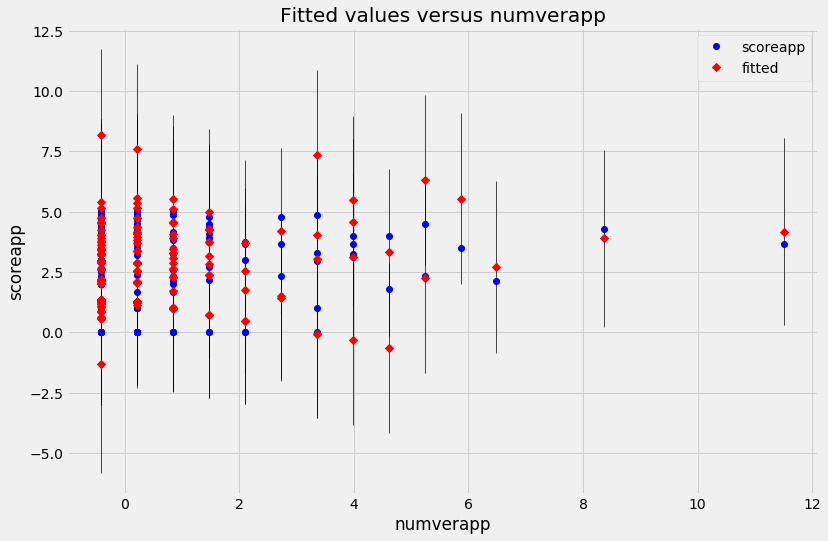

In [45]:
# create figure
fig = plt.figure(figsize=(12, 8)) 

# add plot
ax = fig.add_subplot(1, 1, 1)

# plot data and estimates with Statmodels' built-in 'graphics'
sm.graphics.plot_fit(m_0_res, "numverapp", ax=ax)

# show plot
plt.show()

## Predictions

In [144]:
# fake data on a curvilinear relationship between x and y
nsample = 50
sig = 0.5
x = np.linspace(0, 20, nsample)
X = np.column_stack((x, np.sin(x), (x-5)**2, np.ones(nsample)))
beta = [0.5, 0.5, -0.02, 5.]
y_true = np.dot(X, beta)
y = y_true + sig * np.random.normal(size=nsample)

In [145]:
# estimation
res = sm.OLS(y, X).fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.929
Model:                            OLS   Adj. R-squared:                  0.924
Method:                 Least Squares   F-statistic:                     199.4
Date:                Mon, 21 Oct 2019   Prob (F-statistic):           2.29e-26
Time:                        21:21:07   Log-Likelihood:                -39.421
No. Observations:                  50   AIC:                             86.84
Df Residuals:                      46   BIC:                             94.49
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.4832      0.029     16.563      0.0

In [155]:
# get confidence intervals
y_hat, lb, ub = wls_prediction_std(res)

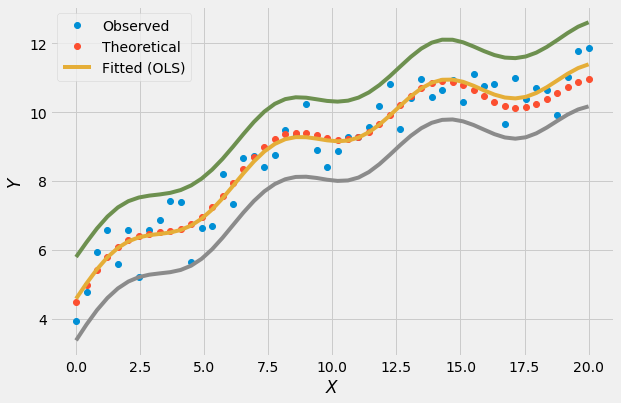

In [158]:
# create figure
fig = plt.figure(figsize=(9, 6))

# add plot
ax = fig.add_subplot(1, 1, 1)

# plot data
ax.plot(x, y, 'o', label="Observed")
ax.plot(x, y_true, 'o', label="Theoretical")
ax.plot(x, res.fittedvalues, label="Fitted (OLS)")
ax.plot(x, ub)
ax.plot(x, lb)

# axes
ax.set_xlabel('$X$')
ax.set_ylabel('$Y$')

# legend
ax.legend(loc='best');